In [475]:
from sbi import utils as utils
from sbi.utils import process_prior, posterior_nn
from sbi import inference as Inference
from scipy import optimize, stats

import torch
from torch.distributions import Distribution, Normal, constraints
import numpy as np
import matplotlib.pyplot as plt
import torch.distributions as dist
import torch

from models.lightcurves import LightCurve
from interpolate_lcs import ugrizy_to_numbers
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
from models.custom_sklearn import train_test_split, StandardScaler

# Note that we are lazily using the CPU, but this is faster w/ a GPU
if torch.cuda.is_available(): device = 'mps'
else: device = 'cpu'
print(f'device is {device}')
torch.set_default_dtype(torch.float32)

import sys
sys.path.append('/Users/adamboesky/Research/SBI_205/models')

# matplotlib formatting
import matplotlib as mpl
plt.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'cmr10'  # Computer Modern Roman
mpl.rcParams['font.size'] = 12  # Adjust the font size as needed
plt.rc('text', usetex=True)

device is cpu


# Take a look at the data

In [476]:
# Import the LCs
lcs = np.load('data/full_lcs_interped.npz', allow_pickle=True)['lcs']
print(lcs.shape)
for lc in lcs:  # adjust the t explosion
    lc.theta[-1] -= min(lc.times)
lcs = lcs[:1000]
lcs.shape

(32643,)


(1000,)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_9939/1140393579.py:15: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = plt.subplots(2, 4, figsize=(12, 6))


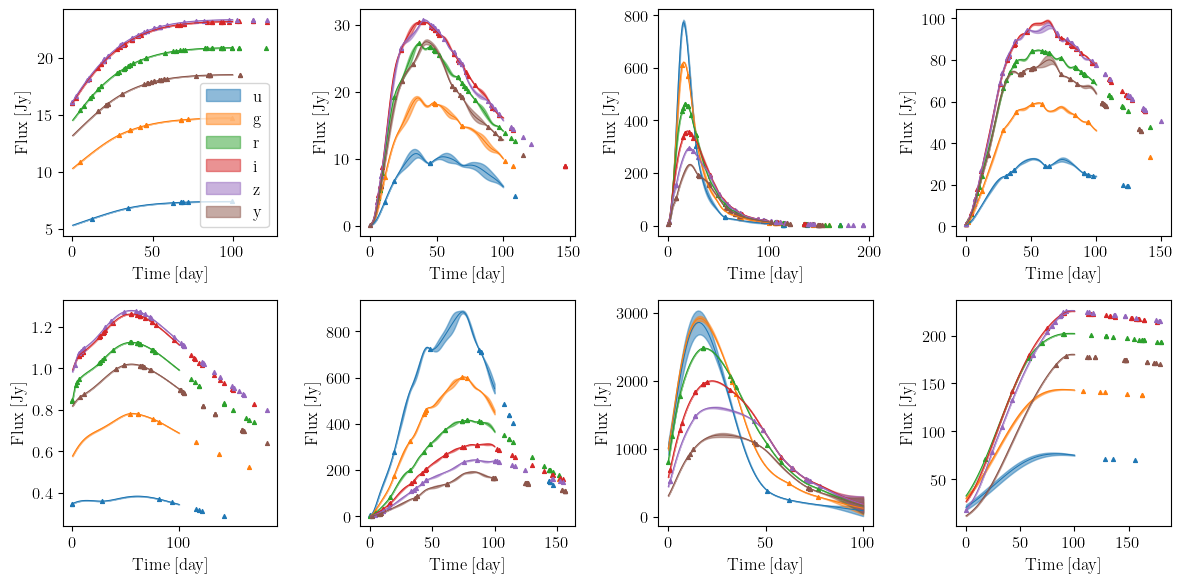

In [477]:
ab_magerr_to_ferr = lambda sigma_m, f: np.abs(f * np.log(10) * (sigma_m / 2.5))  # transformation on the error of a magnitude turned into flux
def ab_mag_to_flux(AB_mag: np.ndarray) -> np.ndarray:
    """Convert AB magnitude to flux in units of mJy"""
    return 10**((AB_mag - 8.9) / -2.5)

band_name_map = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
cmap = plt.get_cmap('tab10')

def plot_grizy(times, mags, filts, ax, cmap = plt.get_cmap('tab10')):
    """Function to plot the true grizy values on a given axis"""
    for band_i in range(len(filts)):
        ax.scatter(times[filts==band_i], mags[filts==band_i], color=cmap(band_i), s=7.5, marker='^')

# Take a look at the light curves
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in zip(range(20, 28), axes.flatten()):

    # Interpolate and plot the predictions
    good_mask = np.isfinite(lcs[i].mags)
    for j in range(6):
        flux = ab_mag_to_flux(lcs[i].mags_interped.reshape(-1, 6)[:,j])
        flux_errs = ab_magerr_to_ferr(lcs[i].magerrs_interped.reshape(-1, 6)[:,j], flux)
        ax.fill_between(np.linspace(0.1,100,100), y1=flux-flux_errs, y2=flux+flux_errs, alpha=0.5, label=band_name_map[j], color=cmap(j))
        ax.plot(np.linspace(0.1,100,100), flux, color=cmap(j), lw=0.75)

    # Plot the original data
    plot_grizy((lcs[i].times - min(lcs[i].times))[good_mask], ab_mag_to_flux(lcs[i].mags[good_mask]), ugrizy_to_numbers(lcs[i].filters)[good_mask], ax)
    ax.set_xlabel('Time [day]')
    ax.set_ylabel('Flux [Jy]')

axes[0,0].legend()
plt.tight_layout()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_9939/433223194.py:18: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = plt.subplots(1, 4, figsize=(15, 3))


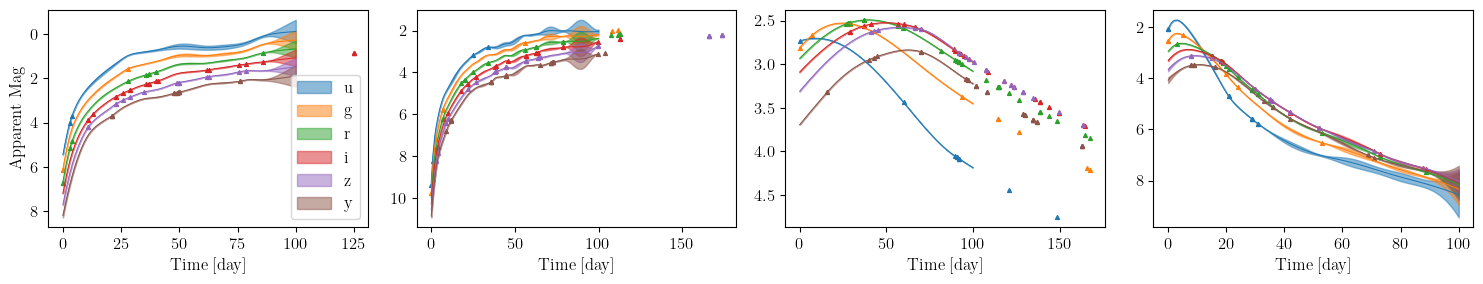

In [479]:
ab_magerr_to_ferr = lambda sigma_m, f: np.abs(f * np.log(10) * (sigma_m / 2.5))  # transformation on the error of a magnitude turned into flux
def ab_mag_to_flux(AB_mag: np.ndarray) -> np.ndarray:
    """Convert AB magnitude to flux in units of mJy"""
    return 10**((AB_mag - 8.9) / -2.5)

band_name_map = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
cmap = plt.get_cmap('tab10')

def plot_grizy(times, mags, filts, ax, cmap = plt.get_cmap('tab10'), label=False):
    """Function to plot the true grizy values on a given axis"""
    for band_i in range(len(np.unique(filts))):
        if label:
            ax.scatter(times[filts==band_i], mags[filts==band_i], color=cmap(band_i), s=7.5, marker='^', label=band_name_map[band_i])
        else:
            ax.scatter(times[filts==band_i], mags[filts==band_i], color=cmap(band_i), s=7.5, marker='^')

# Take a look at the light curves
fig, axes = plt.subplots(1, 4, figsize=(15, 3))
for i, ax in zip(range(69, 73), axes.flatten()):

    # Interpolate and plot the predictions
    good_mask = np.isfinite(lcs[i].mags)
    for j in range(6):
        # flux = ab_mag_to_flux(lcs[i].mags_interped.reshape(-1, 6)[:,j])
        # flux_errs = ab_magerr_to_ferr(lcs[i].magerrs_interped.reshape(-1, 6)[:,j], flux)
        flux = lcs[i].mags_interped.reshape(-1, 6)[:,j]
        flux_errs = lcs[i].magerrs_interped.reshape(-1, 6)[:,j]
        ax.fill_between(np.linspace(0.1,100,100), y1=flux-flux_errs, y2=flux+flux_errs, alpha=0.5, label=band_name_map[j], color=cmap(j))
        ax.plot(np.linspace(0.1,100,100), flux, color=cmap(j), lw=0.75)

    # Plot the original data
    plot_grizy((lcs[i].times - min(lcs[i].times))[good_mask], lcs[i].mags[good_mask], ugrizy_to_numbers(lcs[i].filters)[good_mask], ax)
    ax.set_xlabel('Time [day]')
    ax.invert_yaxis()

axes[0].set_ylabel('Apparent Mag')
axes[0].legend()
plt.savefig('Figures/4_Interpolation_Examples.pdf', bbox_inches='tight')
plt.tight_layout()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_9939/967907278.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1, 1, figsize=(4, 3))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_9939/967907278.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in range(len(leg.legendHandles)):
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_9939/967907278.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[i]._sizes = [35]


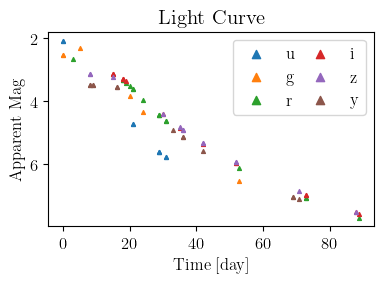

In [484]:
# Take a look at the light curves
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
# for i, ax in zip(range(69, 73), axes.flatten()):

# Interpolate and plot the predictions
i=72
good_mask = np.isfinite(lcs[i].mags)
for j in range(6):
    # flux = ab_mag_to_flux(lcs[i].mags_interped.reshape(-1, 6)[:,j])
    # flux_errs = ab_magerr_to_ferr(lcs[i].magerrs_interped.reshape(-1, 6)[:,j], flux)
    flux = lcs[i].mags_interped.reshape(-1, 6)[:,j]
    flux_errs = lcs[i].magerrs_interped.reshape(-1, 6)[:,j]
    # ax.fill_between(np.linspace(0.1,100,100), y1=flux-flux_errs, y2=flux+flux_errs, alpha=0.5, label=band_name_map[j], color=cmap(j))
    # ax.plot(np.linspace(0.1,100,100), flux, color=cmap(j), lw=0.75)

# Plot the original data
plot_grizy((lcs[i].times - min(lcs[i].times))[good_mask], lcs[i].mags[good_mask], ugrizy_to_numbers(lcs[i].filters)[good_mask], ax, label=True)
ax.set_xlabel('Time [day]', fontsize=12)
ax.invert_yaxis()

ax.set_ylabel('Apparent Mag', fontsize=12)
leg = ax.legend(ncols=2, columnspacing=0.5, )
for i in range(len(leg.legendHandles)):
    leg.legendHandles[i]._sizes = [35]
ax.set_title('Light Curve', fontsize=15)
plt.tight_layout()
plt.savefig('Figures/Interpolation_Example_Original.pdf', bbox_inches='tight')

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_9939/75106390.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1, 1, figsize=(4, 3))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_9939/75106390.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in range(len(leg.legendHandles)):
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_9939/75106390.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[i]._sizes = [35]


python(21211) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21215) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


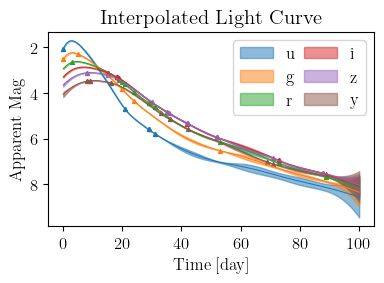

In [485]:
# Take a look at the light curves
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
# for i, ax in zip(range(69, 73), axes.flatten()):

# Interpolate and plot the predictions
i=72
good_mask = np.isfinite(lcs[i].mags)
for j in range(6):
    # flux = ab_mag_to_flux(lcs[i].mags_interped.reshape(-1, 6)[:,j])
    # flux_errs = ab_magerr_to_ferr(lcs[i].magerrs_interped.reshape(-1, 6)[:,j], flux)
    flux = lcs[i].mags_interped.reshape(-1, 6)[:,j]
    flux_errs = lcs[i].magerrs_interped.reshape(-1, 6)[:,j]
    ax.fill_between(np.linspace(0.1,100,100), y1=flux-flux_errs, y2=flux+flux_errs, alpha=0.5, label=band_name_map[j], color=cmap(j))
    ax.plot(np.linspace(0.1,100,100), flux, color=cmap(j), lw=0.75)

# Plot the original data
plot_grizy((lcs[i].times - min(lcs[i].times))[good_mask], lcs[i].mags[good_mask], ugrizy_to_numbers(lcs[i].filters)[good_mask], ax, label=False)
ax.set_xlabel('Time [day]', fontsize=12)
ax.invert_yaxis()

ax.set_ylabel('Apparent Mag', fontsize=12)
leg = ax.legend(ncols=2, columnspacing=0.5, )
for i in range(len(leg.legendHandles)):
    leg.legendHandles[i]._sizes = [35]
ax.set_title('Interpolated Light Curve', fontsize=15)
plt.tight_layout()
plt.savefig('Figures/Interpolation_Example.pdf', bbox_inches='tight')

# Do SBI

The theta attribute of the light curves are, in order, `[pspin, bfield, mns, thetapb, texp, kappa, kappagamma, mej, vej, tfloor]`. These are defined as:
- pspin = Spin Period (in ms)
- bfield = magnetic field in units of 10^14 Gauss
- mns is neutron star mass in Msol
- thetapb - observing angle in radians? but fixed in any case
- kappa = optical opacity in g/cm^2
- kappagamma = opacity of gamma rays in g/cm^2
- mej = ejecta mass in Msol
- vej = ejecta velocity in km/s
- tfloor = a specific, relevant temperature in Kelvin (edited)

*last one is the time of explosion*

In [4]:
# Split into test and train
predictor_mask = np.array([ True,  True, False, False, False, False, False,  True,  True, False,  True]) # Mask for theta that only gets what we actually care about
all_predictor_labels = np.array(['pspin', 'bfield', 'mns', 'thetapb', 'texp', 'kappa', 'kappagamma', 'mej', 'vej', 'tfloor', 'texplosion'])
predictor_labels = all_predictor_labels[predictor_mask]
print(f'theta = {predictor_labels}')

theta = ['pspin' 'bfield' 'mej' 'vej' 'texplosion']


In [5]:
t_exps = np.array([lc.theta[-1] for lc in lcs])
print(f'The mean time of explosion is {np.mean(t_exps)}, and 1/lambda = {1/np.mean(t_exps)}')

The mean time of explosion is -26.96680278369608, and 1/lambda = -0.037082631115787745


In [6]:
class TenExpTransform(dist.transforms.Transform):
    """
    A transformation with the forward operation applying 10^x.
    """
    domain = dist.constraints.real
    codomain = dist.constraints.positive
    bijective = True
    sign = 1
    
    def __eq__(self, other):
        return type(self) == type(other)

    def _call(self, x):
        return 10**x

    def _inverse(self, y):
        return torch.log10(y)

    def log_abs_det_jacobian(self, x, y):
        """
        Return the log determinant of the absolute value of the Jacobian matrix.
        """
        return torch.log(torch.tensor(10.0)) * y


class LogUniform(dist.TransformedDistribution):
    def __init__(self, low: torch.Tensor, high: torch.Tensor):
        self.low = low.log10()
        self.high = high.log10()
        super().__init__(dist.Uniform(low.log10(), high.log10()), TenExpTransform())

    @property
    def support(self):
        return constraints.interval(self.low, self.high)


class TruncatedNormal(Distribution):
    def __init__(self, lower, upper, mu, sigma, validate_args=None):
        self.lower = lower
        self.upper = upper
        self.mu = mu
        self.sigma = sigma
        self.normal = Normal(mu, sigma)

        # Pre-compute the a and b parameters for scipy's truncnorm
        self.a = (self.lower - self.mu) / self.sigma
        self.b = (self.upper - self.mu) / self.sigma
        
        # Calculate normalization constant in log space for numerical stability
        self.Z = (self.normal.cdf(self.upper) - self.normal.cdf(self.lower)).log()
        
        super(TruncatedNormal, self).__init__(batch_shape=self.mu.size(), event_shape=torch.Size(), validate_args=validate_args)

    def sample(self, sample_shape=torch.Size()):
        if not isinstance(sample_shape, tuple):
            sample_shape = (sample_shape,)

        # Generate samples using scipy's truncnorm
        total_shape = sample_shape + self.batch_shape
        total_num_samples = np.prod(total_shape).item()
        samples_np = stats.truncnorm.rvs(self.a, self.b, loc=self.mu.item(), scale=self.sigma.item(), size=total_num_samples)
        samples = torch.from_numpy(samples_np).reshape(total_shape).to(dtype=self.mu.dtype)
        
        return samples

    def log_prob(self, value):
        log_prob = self.normal.log_prob(value) - self.Z
        mask = (value < self.lower) | (value > self.upper)
        log_prob[mask] = float('-inf')
        return log_prob

    @property
    def support(self):
        return constraints.interval(self.lower, self.upper)

    @property
    def mean(self):
        # Placeholder for actual mean calculation of truncated normal
        return self.mu

    @property
    def variance(self):
        # Placeholder for actual variance calculation of truncated normal
        return self.sigma**2


# class CompositeSupport(constraints.Constraint):
#     def __init__(self, supports):
#         self.supports = supports

#     def check(self, value):
#         # Assuming value is structured appropriately for the distributions in CustomPrior
#         checks = torch.stack([
#             self.supports[0].check(value[:, 0]),  # For Uniform distribution
#             self.supports[1].check(value[:, 1:3]),  # For LogUniform distribution
#             self.supports[2].check(value[:, 3])  # For TruncatedNormal distribution
#         ], dim=-1)
#         return torch.all(checks, dim=-1)

# class CustomPrior(dist.Distribution):
#     def __init__(self):
#         self.uniform_prior = dist.Uniform(torch.tensor([0.7]), torch.tensor([20]))                  # pspin, texplosion
#         self.log_uniform_prior = LogUniform(torch.tensor([0.01, 0.1]), torch.tensor([10, 10**1.3])) # bfield, M_ej
#         self.gaussian_prior = TruncatedNormal(torch.tensor([1000]), torch.tensor([30000]), torch.tensor([1.47*1e4]), torch.tensor([4.3*1e4]))

#         # Collect all their supports
#         self._support = CompositeSupport([
#             self.uniform_prior.support, 
#             self.log_uniform_prior.support, 
#             self.gaussian_prior.support
#         ])

#     def sample(self, sample_shape: int = torch.Size()):
#         samples = torch.cat([
#             self.uniform_prior.sample(sample_shape), 
#             self.log_uniform_prior.sample(sample_shape), 
#             self.gaussian_prior.sample(sample_shape)
#         ], dim=-1)
#         return samples

#     def log_prob(self, value: torch.Tensor):
#         # Assuming value is structured with the first column for uniform, next two for log_uniform, and last for gaussian
#         log_prob_uniform = self.uniform_prior.log_prob(value[:, 0])
#         log_prob_log_uniform = self.log_uniform_prior.log_prob(value[:, 1:3])
#         log_prob_gaussian = self.gaussian_prior.log_prob(value[:, 3])

#         # Combine log probabilities
#         return log_prob_uniform + log_prob_log_uniform.sum(dim=-1) + log_prob_gaussian

#     @property
#     def support(self):
#         return self._support

#     def within_support(self, samples):
#         # This method will check if the samples are within the support of all constituent distributions
#         # It assumes `samples` is a tensor where each column corresponds to the samples of one of the distributions
#         # Adjust the slicing according to your actual sample structure
#         uniform_support_check = self.uniform_prior.support.check(samples[:, [0]])
#         log_uniform_support_check = torch.all(self.log_uniform_prior.support.check(samples[:, 1:3]))
#         gaussian_support_check = self.gaussian_prior.support.check(samples[:, [3]])
#         print('here', uniform_support_check, log_uniform_support_check, gaussian_support_check)
        
#         # Combine the checks. All must be true for a sample to be within overall support
#         return uniform_support_check & log_uniform_support_check & gaussian_support_check

In [28]:
from torch.distributions.constraint_registry import ConstraintRegistry
test = TruncatedNormal(torch.tensor([1.]), torch.tensor([3.]), torch.tensor([2.]), torch.tensor([1.]))
bijecter = ConstraintRegistry()
trans = bijecter(test)
# test.sample(torch.Size([10])), test.support

NotImplementedError: Cannot transform TruncatedNormal constraints

In [56]:
from sbi.utils import mcmc_transform

# # Initialize your prior
my_prior, num_params, prior_returns_numpy = process_prior([dist.Uniform(low=torch.tensor([0.1233]), high=torch.tensor([3.522])),        # pspin
                       LogUniform(torch.tensor([0.004464]), torch.tensor([4.4643])),                                                    # bmag
                       LogUniform(torch.tensor([0.0203]), torch.tensor([4.0533])),                                                      # mej
                       dist.Uniform(torch.tensor([-1.653]), torch.tensor([1.8466])),     #    TruncatedNormal(torch.tensor([-1.653]), torch.tensor([1.8466]), torch.tensor([0.0]), torch.tensor([7573])),      # vej
                       dist.Exponential(torch.tensor([1.0]))                                                                            # -1 * texp (mean is 1/25)
                       ])

mcmc_transform(my_prior)

_InverseTransform(IndependentTransform(CatTransform(), 1))

In [7]:
# Get the X and y
X = np.array([np.concatenate((lc.mags_interped.flatten(), lc.magerrs_interped.flatten(), [lc.redshift])) for lc in lcs])
y = np.array([np.array(lc.theta)[predictor_mask] for lc in lcs])[:1000]

# Fit standard scalers to the data
y_scaler = StandardScaler(with_mean=False)
X_scaler = StandardScaler()
y_to_scale = y
y_to_scale[:, 3] = y_to_scale[:, 3] - 1.47*1e4
y_norm = y_scaler.fit_transform(y_to_scale)
X_norm = X_scaler.fit_transform(X)

# Multiply the explosion time by negative one
y_norm[:, -1] *= -1

# # Tack on the explosion time value
# y = np.hstack((y, np.array([lc.theta[-1] for lc in lcs]).reshape(-1, 1)))
# y_norm = np.hstack((y_norm, y[:, -1].reshape(-1, 1)))
# y_norm[:, -1] = y_norm[:, -1] / np.mean(y_norm[:, -1])

In [8]:
# Get array of the prior parameters
y_means, y_stds = y_scaler.mean_, y_scaler.std_
PD_params = [[0.7/y_stds[0], 20/y_stds[0]],
             [0.01/y_stds[1], 10/y_stds[1]],
             [0.1/y_stds[2], 10**1.3/y_stds[2]],
             [(1000-1.47*1e4)/y_stds[3], (30000-1.47*1e4)/y_stds[3], 1.47*1e4, 4.3*1e4/y_stds[0]],
             [1.0]]
for row in PD_params:
    print(row)

[0.12327808587005895, 3.5222310248588276]
[0.004464280019764949, 4.464280019764949]
[0.020314444406701875, 4.053264537422259]
[-1.6534992685088976, 1.8466086721303747, 14700.0, 7572.796703446479]
[1.0]


In [9]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, random_state=22, test_size=0.2)

In [37]:
# Hyperparameters
nhidden = 20
nblocks = 5

# Initialize your prior
my_prior, num_params, prior_returns_numpy = process_prior([dist.Uniform(low=torch.tensor([0.1233]), high=torch.tensor([3.522])),        # pspin
                       LogUniform(torch.tensor([0.004464]), torch.tensor([4.4643])),                                                    # bmag
                       LogUniform(torch.tensor([0.0203]), torch.tensor([4.0533])),                                                      # mej
                       dist.Uniform(torch.tensor([-1.653]), torch.tensor([1.8466])),     #    TruncatedNormal(torch.tensor([-1.653]), torch.tensor([1.8466]), torch.tensor([0.0]), torch.tensor([7573])),      # vej
                       dist.Exponential(torch.tensor([1.0]))                                                                            # -1 * texp (mean is 1/25)
                       ])

# [0.12327808587005895, 3.5222310248588276]
# [0.004464280019764949, 4.464280019764949]
# [0.020314444406701875, 4.053264537422259]
# [-1.6534992685088976, 1.8466086721303747, 14700.0, 7572.796703446479]
# [1.0]

# my_prior, num_params, prior_returns_numpy = process_prior([dist.Uniform(low=torch.tensor([0.7]), high=torch.tensor([20])),              # pspin
#                        LogUniform(torch.tensor([0.01]), torch.tensor([10])),                                                            # bmag
#                        LogUniform(torch.tensor([0.1]), torch.tensor([10**1.3])),                                                        # mej
#                        TruncatedNormal(torch.tensor([1000]), torch.tensor([30000]), torch.tensor([1.47*1e4]), torch.tensor([4.3*1e4])), # vej
#                        dist.Exponential(torch.tensor([1/25]))                                                                           # -1 * texp
#                        ])

# Flow!
anpe = Inference.SNPE(
    prior=my_prior,
    density_estimator=utils.posterior_nn('maf', hidden_features=nhidden, num_transforms=nblocks),
    device=device
)
anpe.append_simulations(
    torch.as_tensor(y_train.astype(np.float32)),
    torch.as_tensor(X_train.astype(np.float32)))
p_x_y_estimator = anpe.train(stop_after_epochs=1000)

# Get the posterior
hatp_x_y = anpe.build_posterior(p_x_y_estimator)

 Neural network successfully converged after 1136 epochs.

AssertionError: Original and re-transformed parameters must be close to each other.

In [32]:
index = 89
samples = hatp_x_y.sample((500,), x=X_test[[index]]).numpy()
fig, axes = plt.subplots(1, 5, figsize=(15, 4))
for i in range(5):
    axes[i].hist(samples[:, i], bins=20, alpha=0.5, density=True)
    # axes[i].hist(y_train[:, i], alpha=0.5, density=True)
    axes[i].axvline(y_test[index][i], color='k')
    axes[i].set_xlabel(predictor_labels[i])

NameError: name 'hatp_x_y' is not defined

# Autoencode Light Curves

In [7]:
# Import the LCs
lcs = np.load('full_lcs_interped.npz', allow_pickle=True)['lcs']
print(lcs.shape)
lcs = np.array([lc for lc in lcs if np.mean(lc.snrs) > 3])
print(lcs.shape)
for lc in lcs:  # adjust the t explosion
    lc.theta[-1] -= min(lc.times)
lcs.shape

(32643,)
(12525,)


(12525,)

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, latent_dim)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 100)
        self.fc2 = nn.Linear(100, 300)
        self.fc3 = nn.Linear(300, output_dim)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self, input_dim=600, latent_dim=20):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def encode(self, x):
        return self.encoder.forward(x)

    def decode(self, x):
        return self.decoder.forward(x)

In [9]:
# Get the LCs
X = np.array([np.concatenate((lc.mags_interped, lc.magerrs_interped)) for lc in lcs])
print(X.shape)

# Normalize some light curves
lc_scaler = StandardScaler()
X_norm = lc_scaler.fit_transform(X)

(12525, 1200)


In [10]:
from torch.utils.data import DataLoader, TensorDataset

# Create a TensorDataset and DataLoader for batch processing
X_norm_tensor = torch.tensor(X_norm, dtype=torch.float32)
dataset = TensorDataset(X_norm_tensor)
data_loader = DataLoader(dataset, batch_size=256, shuffle=True)

# Instantiate the model, loss function, and optimizer
model = Autoencoder(input_dim=1200, latent_dim=25)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 1000
model.train()
losses = []
best_loss = float('inf')
epochs_since_improvement = 0
improvement_threshold = 100
losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for data in data_loader:
        inputs = data[0]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)

    epoch_loss /= len(data_loader.dataset)
    losses.append(epoch_loss)

    # Check for improvement
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1

    # Logging
    if (epoch+1) % 100 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Auto-stop
    if epochs_since_improvement == improvement_threshold:
        print(f"No improvement in loss for {improvement_threshold} consecutive epochs, stopping training.")
        break

model.eval()

Epoch [1/1000], Loss: 0.3354
Epoch [100/1000], Loss: 0.0140
Epoch [200/1000], Loss: 0.0195
Epoch [300/1000], Loss: 0.0043
Epoch [400/1000], Loss: 0.0032
No improvement in loss for 100 consecutive epochs, stopping training.


Autoencoder(
  (encoder): Encoder(
    (fc1): Linear(in_features=1200, out_features=300, bias=True)
    (fc2): Linear(in_features=300, out_features=100, bias=True)
    (fc3): Linear(in_features=100, out_features=25, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=25, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=300, bias=True)
    (fc3): Linear(in_features=300, out_features=1200, bias=True)
  )
)

Parameter containing:
tensor([[-0.2421, -0.2713, -0.2073,  ..., -0.1666, -0.1323, -0.0669],
        [ 0.0493,  0.0840,  0.0877,  ..., -0.1198, -0.0813, -0.0338],
        [-0.0482, -0.0185, -0.0661,  ...,  0.0392,  0.0200,  0.0248],
        ...,
        [ 0.2706,  0.2306,  0.2523,  ..., -0.0419, -0.0426, -0.0510],
        [ 0.0465,  0.0335,  0.0626,  ..., -0.0502, -0.0551, -0.0736],
        [ 0.0367,  0.0021,  0.0320,  ..., -0.0453, -0.0562, -0.1274]],
       requires_grad=True)

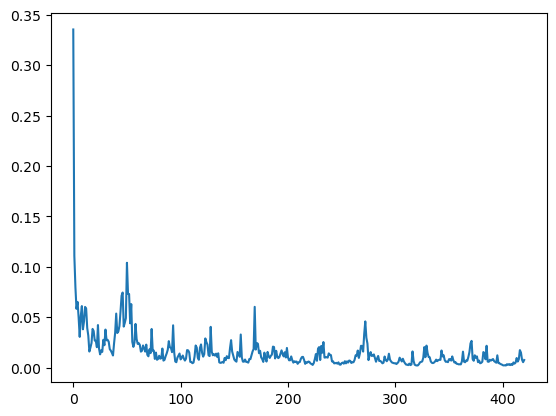

In [11]:
plt.plot(losses)
model.encoder.fc1.weight

(array([4.000e+00, 2.000e+00, 4.000e+00, 9.000e+00, 1.100e+01, 1.100e+01,
        1.300e+01, 1.400e+01, 1.200e+01, 1.300e+01, 6.000e+00, 5.000e+00,
        7.000e+00, 5.000e+00, 6.000e+00, 4.000e+00, 2.000e+00, 5.000e+00,
        5.000e+00, 3.000e+00, 1.000e+00, 6.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.100e+01, 8.000e+00, 1.700e+01, 2.000e+01, 2.500e+01,
        3.400e+01, 5.100e+01, 5.500e+01, 8.000e+01, 1.040e+02, 1.260e+02,
        1.880e+02, 2.580e+02, 3.320e+02, 4.590e+02, 6.670e+02, 9.990e+02,
        1.338e+03, 1.570e+03, 1.697e+03, 1.606e+03, 1.243e+03, 8.140e+02,
        1.740e+02, 4.980e+02]),
 array([-8.41923714e+00, -8.22325706e+00, -8.02727795e+00, -7.83129787e+00,
        -7.63531828e+00, -7.43933868e+00, -7.24335909e+00, -7.04737949e+00,
        -6.85139990e+00, -6.65541983e+00, -6.45944023e+00, -6.26346064e+00,
        -6.06748104e+00, -5.87150145e+00, -5.67552185e+00, -5.47954178e+00,
        -5.28356218e+00, -5.08758259e+00, -4.89160299e+00, -4.69562340e+

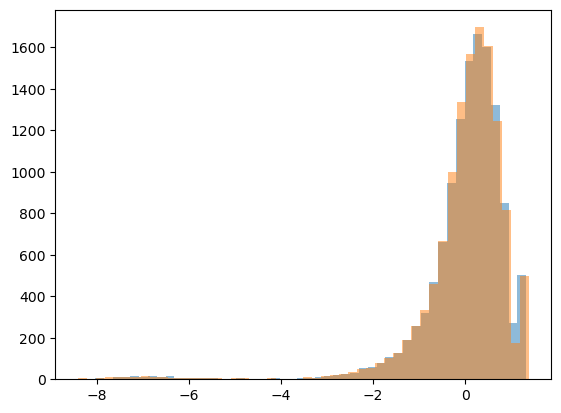

In [12]:
plt.hist(X_norm[:, 100], bins=50, alpha=0.5)
plt.hist(model(torch.Tensor(X_norm)).detach().numpy()[:, 100], bins=50, alpha=0.5)

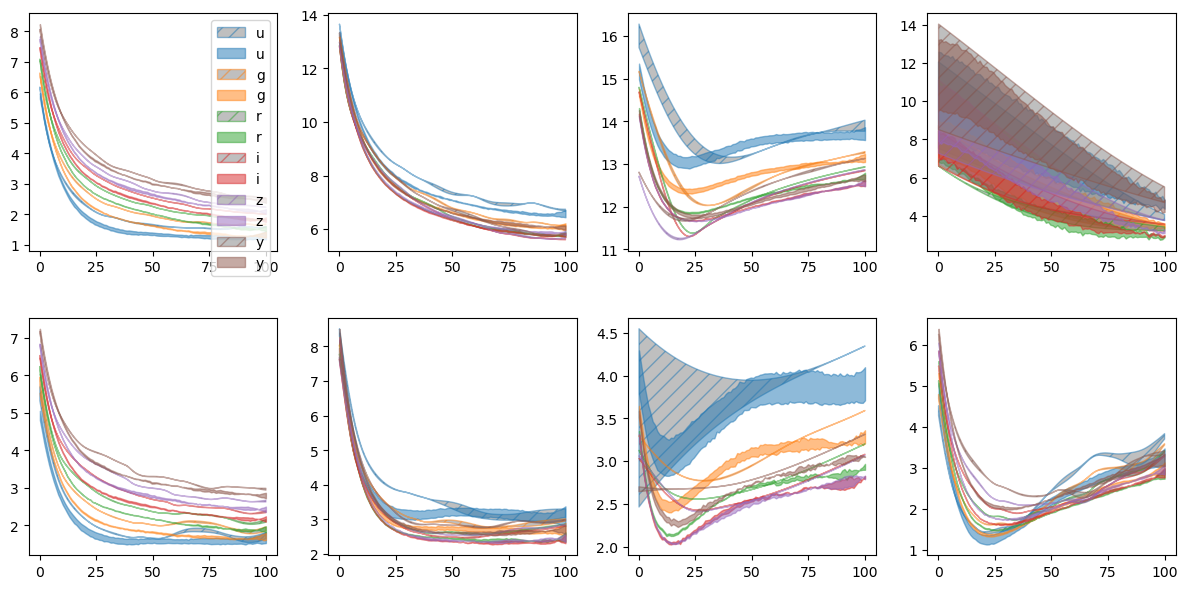

In [13]:
band_name_map = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
cmap = plt.get_cmap('tab10')

# Take a look at the light curves
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()[:8]):

    # Run through encoder
    original_lc = lc_scaler.inverse_transform(X_norm)[i]
    lc_pred = lc_scaler.inverse_transform(model.forward(torch.tensor(X_norm[i].reshape(1, -1), dtype=torch.float32)).detach().numpy()).flatten()

    # Plot the true and inferred
    for j in range(6):
        ax.fill_between(np.linspace(0.1,100,100), y1=original_lc[:600][j::6] - original_lc[600:][j::6], y2=original_lc[:600][j::6] + original_lc[600:][j::6], alpha=0.5, label=band_name_map[j], color=cmap(j), hatch='//', fc='gray')
        # ax.fill_between(np.linspace(0.1,100,100), y1=lcs[i].mags_interped.reshape(-1, 6)[:,j] - lcs[i].magerrs_interped.reshape(-1, 6)[:,j], y2=lcs[i].mags_interped.reshape(-1, 6)[:,j] + lcs[i].magerrs_interped.reshape(-1, 6)[:, j], alpha=0.5, label=band_name_map[j], color=cmap(j))
        ax.fill_between(np.linspace(0.1,100,100), y1=lc_pred[:600][j::6] - lc_pred[600:][j::6], y2=lc_pred[:600][j::6] + lc_pred[600:][j::6], alpha=0.5, label=band_name_map[j], color=cmap(j))

axes[0,0].legend()
plt.tight_layout()

In [461]:
from corner import corner

# Plot the latent space values
latent_space = model(torch.Tensor(X_norm)).detach().numpy()[:, :4]
fig = plt.figure(figsize=(10, 10))
figure = corner(latent_space,
                fig=fig,
                labels=[rf"$z_{i}$" for i in range(latent_space.shape[1])],
                show_titles=True,
                label_kwargs={"fontsize": 15},
                title_kwargs={"fontsize": 15},
                color='rebeccapurple')

NameError: name 'model' is not defined

# SBI on Encoded Light Curves

In [19]:
# Split into test and train
predictor_mask = np.array([ True,  True, False, False, False, False, False,  True,  True, False,  True])  # mask for theta that only gets what we actually care about
all_predictor_labels = np.array(['pspin', 'bfield', 'mns', 'thetapb', 'texp', 'kappa', 'kappagamma', 'mej', 'vej', 'tfloor', 'texplosion'])
predictor_labels = all_predictor_labels[predictor_mask]
print(f'theta = {predictor_labels}')

theta = ['pspin' 'bfield' 'mej' 'vej' 'texplosion']


In [20]:
t_exps = np.array([lc.theta[-1] for lc in lcs])
print(f'The mean time of explosion is {np.mean(t_exps)}, and 1/lambda = {1/np.mean(t_exps)}')

The mean time of explosion is -26.96680278369608, and 1/lambda = -0.037082631115787745


In [105]:
# Load our data
import pickle
with open('data/full_encoded_lcs.pkl', 'rb') as f:
    latent_space, lcs = pickle.load(f)

In [115]:
# Get the X and y
latent_space_subset = latent_space[:1000]
lcs_subset = lcs[:1000]
X_encoded = np.array([np.concatenate((lc_encoding, [lc.redshift])) for lc_encoding, lc in zip(latent_space_subset, lcs_subset)])
y = np.array([np.array(lc.theta)[predictor_mask] for lc in lcs_subset])

# # Fit standard scalers to the data
# y_scaler = StandardScaler(with_mean=False)
# y_to_scale = y
# y_to_scale[:, 3] = y_to_scale[:, 3] - 1.47*1e4
# y_to_scale[:, 1] = np.log10(y_to_scale[:, 1])
# y_to_scale[:, 2] = np.log10(y_to_scale[:, 2])
# y_norm = y_scaler.fit_transform(y_to_scale)
# y_norm[:, -1] *= -1  # multiply the explosion time by negative one

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_9939/2678077020.py:3: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = plt.subplots(1, 5, figsize=(20, 4))


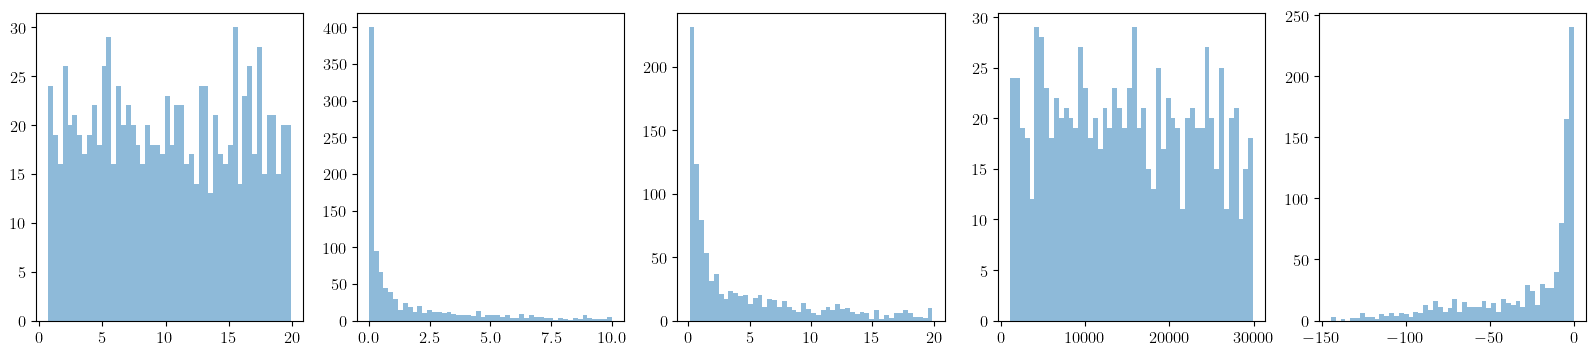

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_9939/2678077020.py:10: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = plt.subplots(1, 5, figsize=(20, 4))


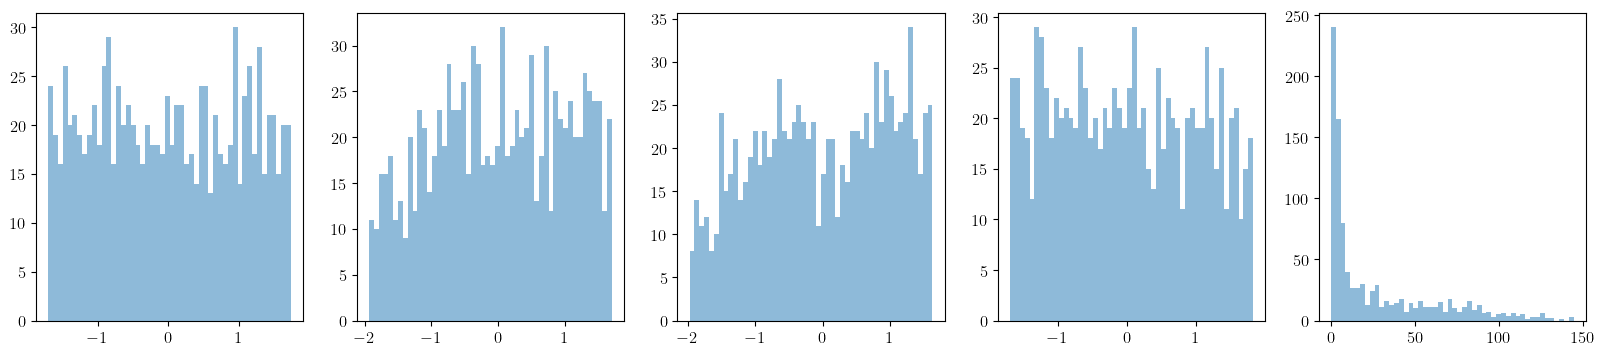

In [136]:
y = np.array([np.array(lc.theta)[predictor_mask] for lc in lcs_subset])

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# Plot original data
for i in range(5):
    axes[i].hist(y[:, i], alpha=0.5, bins=50)
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# Fiddle with the data
y[:, -1] *= -1  # multiply the explosion time by negative one
y[:, 1] = np.log10(y[:, 1])
y[:, 2] = np.log10(y[:, 2])
y_means = np.mean(y, axis=0)
y_stds = np.std(y, axis=0)
y_norm = y
y_norm[:, :-1] -= y_means[:-1]
y_norm[:, :-1] /= y_stds[:-1]
for i in range(5):
    axes[i].hist(y_norm[:, i], alpha=0.5, bins=50)
plt.show()

In [137]:
# Get array of the prior distribution parameters
# y_means, y_stds = y_scaler.mean_, y_scaler.std_
# PD_params = [[0.7/y_stds[0], 20/y_stds[0]],
#              [np.log10(0.01)/y_stds[1], np.log10(10)/y_stds[1]],
#              [np.log10(0.1)/y_stds[2], np.log10(10**1.3)/y_stds[2]],
#              [(1000-1.47*1e4)/y_stds[3], (30000-1.47*1e4)/y_stds[3], 0.0, 4.3*1e4/y_stds[0]],
#              [1.0]]
PD_params = [[np.min(y_norm[:, 0]), np.max(y_norm[:, 0])],
             [np.min(y_norm[:, 1]), np.max(y_norm[:, 1])],
             [np.min(y_norm[:, 2]), np.max(y_norm[:, 2])],
             [np.min(y_norm[:, 3]), np.max(y_norm[:, 3])],
             [1/y_means[-1]]]

# Need to round them to be compatible with SBI
for i, row in enumerate(PD_params):
    for j, val in enumerate(row):
        PD_params[i][j] = float(round(val, 4))

for row in PD_params:
    print(row)

# y_norm[:, 1] = np.log10(y_norm[:, 1])
# y_norm[:, 2] = np.log10(y_norm[:, 2])

[-1.7001, 1.7315]
[-1.9394, 1.702]
[-1.9715, 1.6292]
[-1.6827, 1.8219]
[0.0363]


In [138]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_norm, random_state=22, test_size=0.2)

/Users/adamboesky/opt/anaconda3/envs/sbi2/lib/python3.12/site-packages/sbi/utils/user_input_checks.py:76: UserWarning: Prior was provided as a sequence of 5 priors. They will be
            interpreted as independent of each other and matched in order to the
            components of the parameter.
  warnings.warn(
/Users/adamboesky/opt/anaconda3/envs/sbi2/lib/python3.12/site-packages/sbi/utils/user_input_checks.py:209: UserWarning: Casting 1D Uniform prior to BoxUniform to match sbi batch requirements.
  warnings.warn(
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_9939/1298110435.py:8: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = plt.subplots(1, 5, figsize=(20, 4))


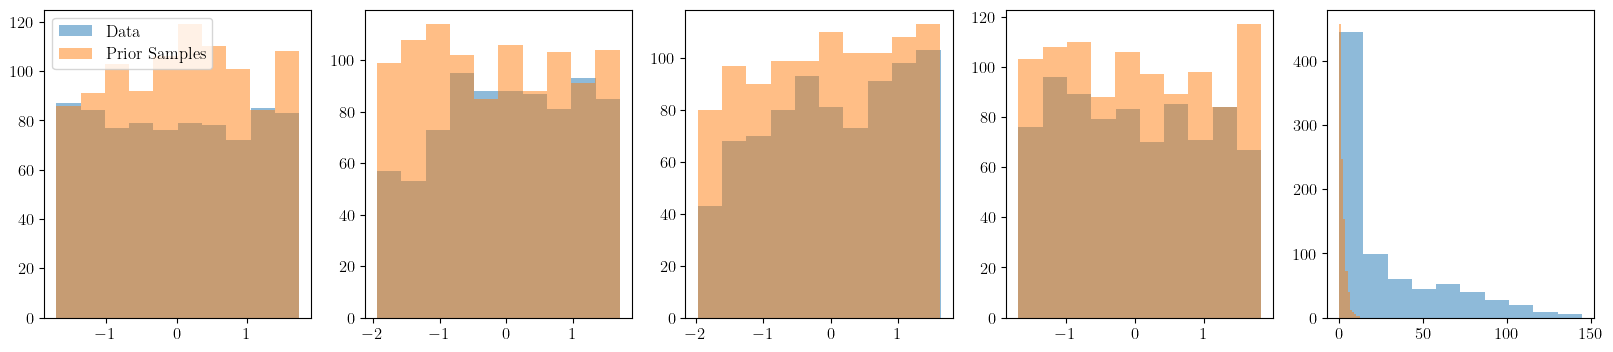

In [315]:
my_prior, num_params, prior_returns_numpy = process_prior([dist.Uniform(low=torch.tensor([PD_params[0][0]]), high=torch.tensor([PD_params[0][1]])),        # pspin
                       dist.Uniform(torch.tensor([PD_params[1][0]]), torch.tensor([PD_params[1][1]])),                                                    # bmag
                       dist.Uniform(torch.tensor([PD_params[2][0]]), torch.tensor([PD_params[2][1]])),                                                      # mej
                       dist.Uniform(torch.tensor([PD_params[3][0]]), torch.tensor([PD_params[3][1]])),      # vej
                       dist.Exponential(torch.tensor([0.5]))                                                                            # -1 * texp (mean is 1/25)
                       ])

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
samples = my_prior.sample(sample_shape=torch.Size([1000]))
for i in range(5):
    axes[i].hist(y_train[:, i], alpha=0.5, label='Data')
    axes[i].hist(samples[:, i], alpha=0.5, label='Prior Samples')
axes[0].legend()
plt.show()

In [148]:
# Hyperparameters
nhidden = 20
nblocks = 5

# Initialize your prior
# my_prior, num_params, prior_returns_numpy = process_prior([dist.Uniform(low=torch.tensor([PD_params[0][0]]), high=torch.tensor([PD_params[0][1]])),        # pspin
#                        LogUniform(torch.tensor([PD_params[1][0]]), torch.tensor([PD_params[1][1]])),                                                    # bmag
#                        LogUniform(torch.tensor([PD_params[2][0]]), torch.tensor([PD_params[2][1]])),                                                      # mej
#                        TruncatedNormal(torch.tensor([PD_params[3][0]]), torch.tensor([PD_params[3][1]]), torch.tensor([PD_params[3][2]]), torch.tensor([PD_params[3][3]])),      # vej
#                        dist.Exponential(torch.tensor([PD_params[4][0]]))                                                                            # -1 * texp (mean is 1/25)
#                        ])

my_prior, num_params, prior_returns_numpy = process_prior([dist.Uniform(low=torch.tensor([PD_params[0][0]]), high=torch.tensor([PD_params[0][1]])),        # pspin
                       dist.Uniform(torch.tensor([PD_params[1][0]]), torch.tensor([PD_params[1][1]])),                                                    # bmag
                       dist.Uniform(torch.tensor([PD_params[2][0]]), torch.tensor([PD_params[2][1]])),                                                      # mej
                       dist.Uniform(torch.tensor([PD_params[3][0]]), torch.tensor([PD_params[3][1]])),      # vej
                       dist.Exponential(torch.tensor([PD_params[4][0]]))                                                                            # -1 * texp (mean is 1/25)
                       ])

# Flow!
anpe = Inference.SNPE(
    prior=my_prior,
    density_estimator=utils.posterior_nn('maf', hidden_features=nhidden, num_transforms=nblocks),
    device=device
)
anpe.append_simulations(
    torch.as_tensor(y_train.astype(np.float32)),
    torch.as_tensor(X_train.astype(np.float32)),
    proposal=None)
p_x_y_estimator = anpe.train(stop_after_epochs=1000)

# Get the posterior
hatp_x_y = anpe.build_posterior(p_x_y_estimator, prior=my_prior)

 Neural network successfully converged after 1126 epochs.

Drawing 500 posterior samples: 529it [00:00, 6059.03it/s]             
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_9939/3542395362.py:3: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = plt.subplots(1, 5, figsize=(15, 4))


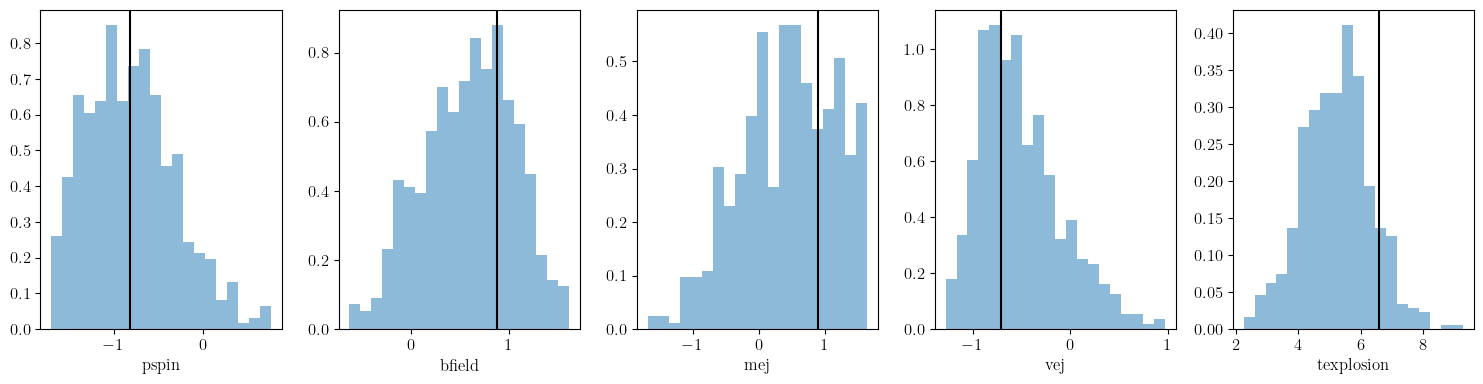

In [194]:
index = 10
samples = hatp_x_y.sample((500,), x=X_test[[index]]).numpy()
fig, axes = plt.subplots(1, 5, figsize=(15, 4))
for i in range(5):
    axes[i].hist(samples[:, i], bins=20, alpha=0.5, density=True)
    axes[i].axvline(y_test[index][i], color='k')
    axes[i].set_xlabel(predictor_labels[i])
plt.tight_layout()

/Users/adamboesky/opt/anaconda3/envs/sbi2/lib/python3.12/site-packages/corner/core.py:126: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/adamboesky/opt/anaconda3/envs/sbi2/lib/python3.12/site-packages/corner/core.py:290: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax.set_xscale(axes_scale[i])
/Users/adamboesky/opt/anaconda3/envs/sbi2/lib/python3.12/site-packages/corner/core.py:290: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax.set_xscale(axes_scale[i])
/Users/adamboesky/opt/anaconda3/envs/sbi2/lib/python3.12/site-packages/corner/core.py:799: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax.set_xscale(axes_scale[0])
/Users/adamboesky/opt/anaconda3/envs/sbi2/lib/python3.12/site-packages/corner/core.

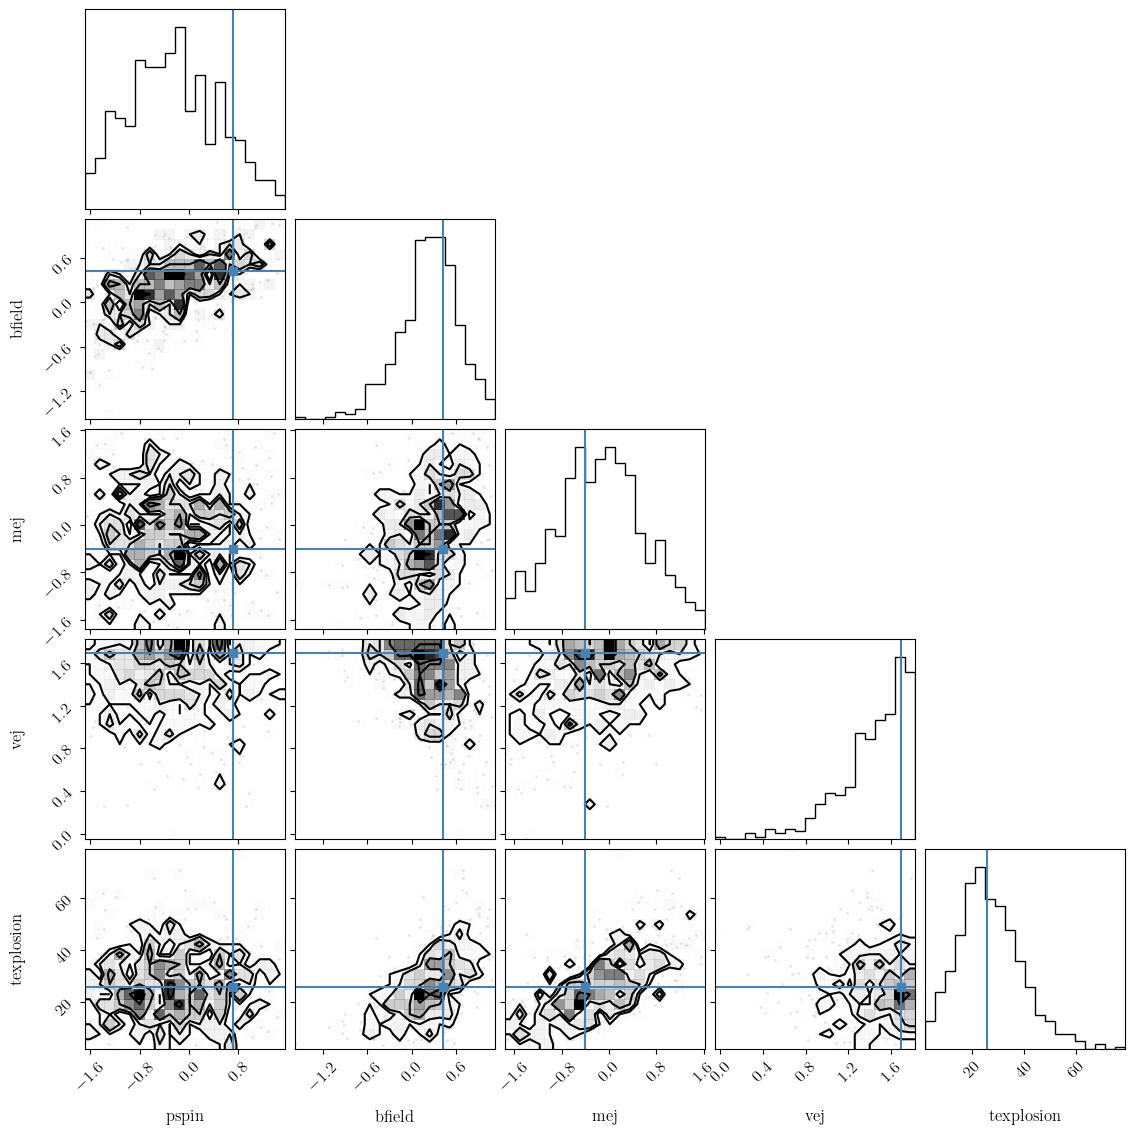

In [146]:
import corner
fig = corner.corner(
    samples, labels=predictor_labels, truths=y_test[index]
)

# Do MCMC

In [19]:
import emcee
from magnetar_model import gen_magnetar_model
from astropy.cosmology import Planck18 as cosmo

In [ ]:
# Get array of the prior parameters
y_means, y_stds = y_scaler.mean_, np.sqrt(y_scaler.var_)
PD_params = [[0.7/y_stds[0], 20/y_stds[0]],
             [0.01/y_stds[1], 10/y_stds[1]],
             [0.1/y_stds[2], 10**1.3/y_stds[2]],
             [(1000-1.47*1e4)/y_stds[3], (30000-1.47*1e4)/y_stds[3], 1.47*1e4, 4.3*1e4/y_stds[0]],
             [1.0]]
for row in PD_params:
    print(row)

[0.12327808587005895, 3.5222310248588276]
[0.004464280019764949, 4.464280019764949]
[0.020314444406701875, 4.053264537422259]
[-1.6534992685088976, 1.8466086721303747, 14700.0, 7572.796703446479]
[1.0]


In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, random_state=22, test_size=0.2)

In [266]:
# Initialize prior for MCMC
mcmc_prior, num_params, prior_returns_numpy = process_prior([dist.Uniform(low=torch.tensor([0.7]), high=torch.tensor([20])),        # pspin
                       LogUniform(torch.tensor([0.01]), torch.tensor([10])),                                                    # bmag
                       LogUniform(torch.tensor([0.1]), torch.tensor([10**1.3])),                                                      # mej
                       TruncatedNormal(torch.tensor([1000]), torch.tensor([30000]), torch.tensor([1.47*1e4]), torch.tensor([4.3*1e4])),      # vej
                       dist.Exponential(torch.tensor([1/0.2]))
                    #    dist.Exponential(torch.tensor([1/27]))   # -1 * texp (mean is 27)
                       ])

/Users/adamboesky/Research/SBI_205/magnetar_model.py:65: RuntimeWarning: invalid value encountered in divide
  temperature = (0. * temperature) + (temperature * notgind) + (tfloor[:, None] * gind)
/Users/adamboesky/Research/SBI_205/magnetar_model.py:81: RuntimeWarning: divide by zero encountered in log10
  # mej = 3.2037
/Users/adamboesky/Research/SBI_205/magnetar_model.py:84: RuntimeWarning: divide by zero encountered in log10
  # redshift = 0.307
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_26862/2419798929.py:4: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(test_lc)


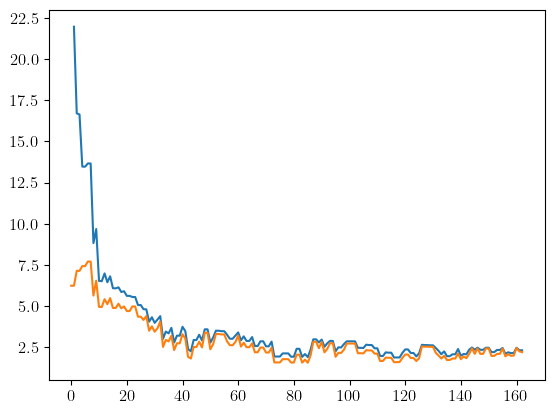

In [116]:
lumdist = cosmo.luminosity_distance(lcs[0].redshift)
dist_const =  np.log10(4. * np.pi * (lumdist.cgs.value) ** 2)
test_lc = gen_magnetar_model(lcs[0].times - lcs[0].times[0], lcs[0].theta[:-1], filt=ugrizy_to_numbers(lcs[0].filters).astype(int), redshift=lcs[0].redshift, dist_const=dist_const)
plt.plot(test_lc)
plt.plot(lcs[0].mags)

In [120]:
# Tensorize the data
ts = torch.tensor([lc.times_interped - lc.times_interped[0] for lc in lcs])
thetas = torch.tensor([lc.theta])[:, predictor_mask][:, :-1]
filters = torch.tensor([ugrizy_to_numbers(lcs[0].filters).astype(int)])
zs = torch.tensor([lc.redshift for lc in lcs]).reshape(-1, 1)
lumdists = cosmo.luminosity_distance(zs)
dist_consts = torch.tensor(np.log10(4. * np.pi * (lumdist.cgs.value) ** 2).reshape(-1, 1))
ys = torch.tensor([lc.mags_interped for lc in lcs])
yerrs = torch.tensor([lc.magerrs_interped for lc in lcs])

In [277]:
import importlib
# importlib.reload(models.magnetar_model)
from models.magnetar_model import gen_magnetar_model

from multiprocessing import Pool
import os
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

In [284]:
# Fixed parameters in our MCMC (these were fixed by prof. Villar in simulation)
mns = 1.40000000e+00
thetapb = 1.57079633e+00
texp = 0.00000000e+00
kappa = 1.12600000e-01
kappagamma = 1.00000000e-01
tfloor = 6.00000000e+03
filt_grid = np.tile(np.linspace(0,5,6),100).astype(int)
time_grid = np.repeat(np.linspace(0.1,100,100),6)

def log_likelihood(y, yerr, theta, z, dist_const):
    """Chi squared likelihood of the SLSN model."""
    y_pred = gen_magnetar_model(time_grid,
                                torch.tensor([theta[0], theta[1], mns, thetapb, texp, kappa, kappagamma, theta[2], theta[3], tfloor]),
                                filt=filt_grid,
                                redshift=z,
                                dist_const=dist_const)
    sigma_sq = yerr**2 + 10**theta[-1]  # adding a white noise term for underestimated noise
    chi_sq = -0.5 * torch.nansum((y - y_pred) ** 2 / sigma_sq + np.log(2 * np.pi * sigma_sq))
    return chi_sq

def log_probability(theta, y, yerr, z, dist_const):
    """Log probability."""
    lp = mcmc_prior.log_prob(torch.tensor(theta))
    if not np.isfinite(lp):
        return -np.inf

    ll = log_likelihood(y, yerr, theta, z, dist_const)
    return (lp + ll).detach().numpy()


# Parameters for MCMC
nwalkers = 50
p0 = mcmc_prior.sample(sample_shape=torch.Size([50,]))
dtype = [("log_prior", float), ("mean", float)]

# Multithreaded MCMC
with Pool() as pool:

    # Initialize the sampler
    sampler = emcee.EnsembleSampler(nwalkers, num_params, log_probability, args=(ys, yerrs, zs, dist_consts), blobs_dtype=dtype, pool=pool)

    # Run 100 burn in steps :)
    print('Start MCMC')
    burn_results = sampler.run_mcmc(p0, 100, progress=True)
    print('Finished MCMC')
    sampler.reset()

Start MCMC


KeyboardInterrupt: 

In [287]:
def thread_fn(n):
    print(n)
    time.sleep(2)  # For a live example

if __name__=='__main__':
    with Pool() as pool:
        tasks = list(range(24))  # Args for thread_fn
        pool.map(thread_fn, tasks)  # Start all processes

KeyboardInterrupt: 

In [241]:
# Run the real mcmc
final_results = sampler.run_mcmc(burn_results, 10000, progress=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

/Users/adamboesky/Research/SBI_205/magnetar_model.py:62: RuntimeWarning: divide by zero encountered in power
  multiplier =  (1.0 - np.exp(-A*test_t**-2)) * np.exp(-(test_t/tau_diff)**2)
  0%|          | 49/10000 [01:49<5:33:55,  2.01s/it]/Users/adamboesky/Research/SBI_205/magnetar_model.py:60: RuntimeWarning: overflow encountered in multiply
  integrand = 2* lum_inp * test_t/tau_diff * np.exp((test_t/tau_diff)**2)  * 1e52
/Users/adamboesky/Research/SBI_205/magnetar_model.py:75: RuntimeWarning: overflow encountered in power
  radius = np.sqrt(luminosities / (STEF_CONST * temperature**4))
/Users/adamboesky/Research/SBI_205/magnetar_model.py:75: RuntimeWarning: invalid value encountered in divide
  radius = np.sqrt(luminosities / (STEF_CONST * temperature**4))
  1%|          | 56/10000 [02:02<5:09:01,  1.86s/it]/Users/adamboesky/Research/SBI_205/magnetar_model.py:60: RuntimeWarning: overflow encountered in exp
  integrand = 2* lum_inp * test_t/tau_diff * np.exp((test_t/tau_diff)**2)  * 1

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_26862/3048873441.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)


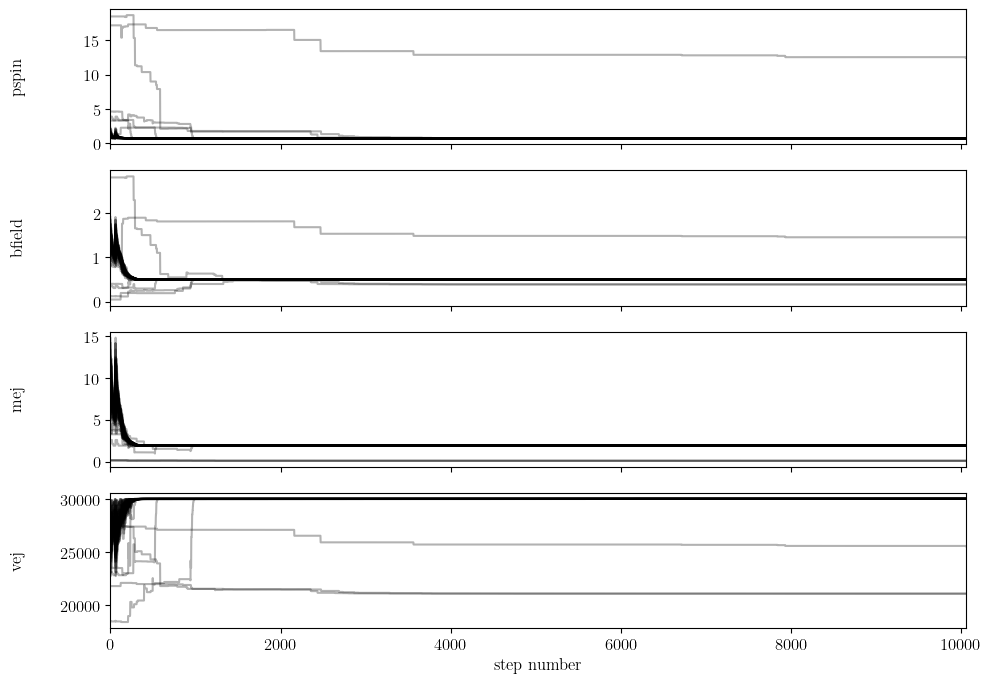

In [260]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(predictor_labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.tight_layout()
plt.show()

In [248]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(33200, 4)


/Users/adamboesky/opt/anaconda3/envs/sbi2/lib/python3.12/site-packages/corner/core.py:126: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/adamboesky/opt/anaconda3/envs/sbi2/lib/python3.12/site-packages/corner/core.py:290: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax.set_xscale(axes_scale[i])
/Users/adamboesky/opt/anaconda3/envs/sbi2/lib/python3.12/site-packages/corner/core.py:290: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax.set_xscale(axes_scale[i])
/Users/adamboesky/opt/anaconda3/envs/sbi2/lib/python3.12/site-packages/corner/core.py:799: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax.set_xscale(axes_scale[0])
/Users/adamboesky/opt/anaconda3/envs/sbi2/lib/python3.12/site-packages/corner/core.

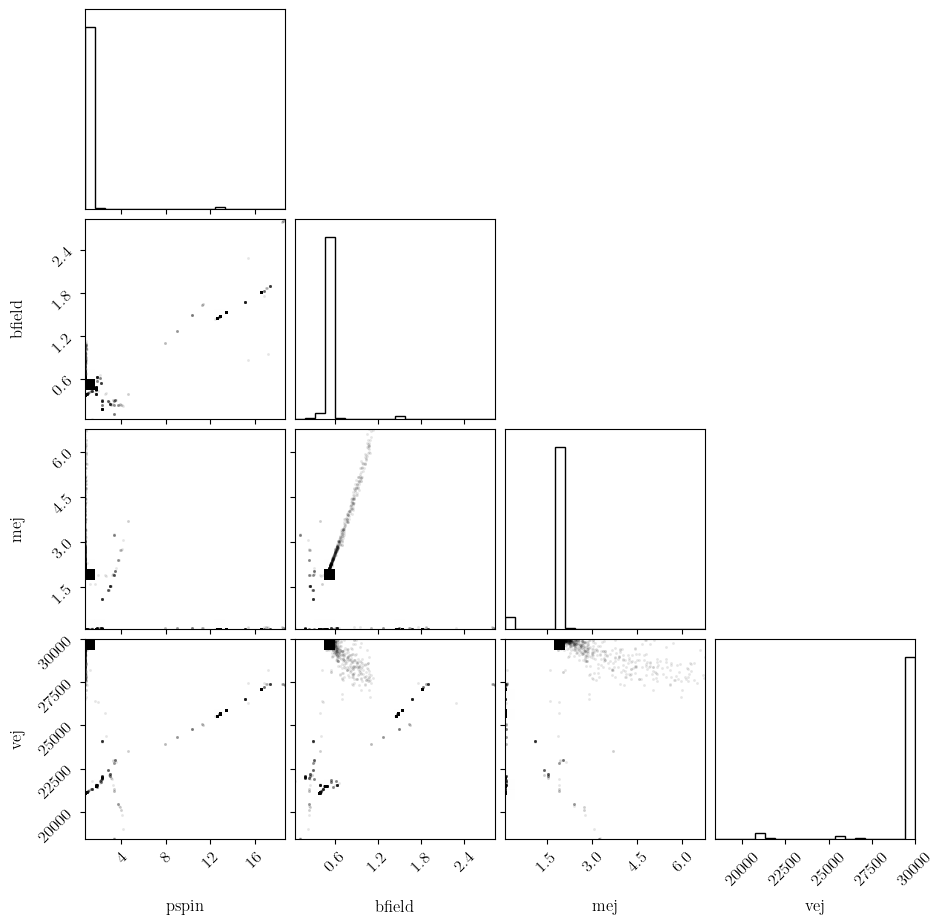

In [252]:
fig = corner.corner(
    flat_samples, labels=predictor_labels[:-1]
)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_26862/1889806441.py:3: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(chain.flatten(), 100)


[]

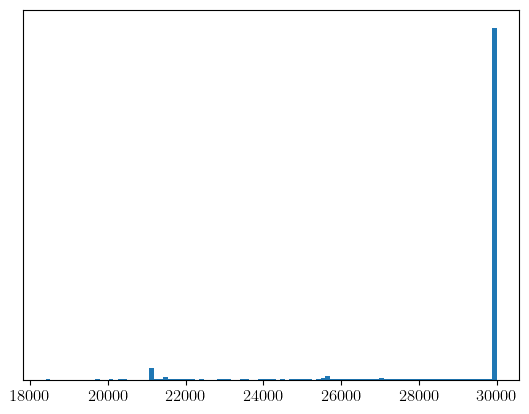

In [256]:
chain = sampler.get_chain()[:, :, 3].T

plt.hist(chain.flatten(), 100)
plt.gca().set_yticks([])

In [262]:
# Fixed parameters in our MCMC (these were fixed by prof. Villar in simulation)
mns = 1.40000000e+00
thetapb = 1.57079633e+00
texp = 0.00000000e+00
kappa = 1.12600000e-01
kappagamma = 1.00000000e-01
tfloor = 6.00000000e+03
filt_grid = np.tile(np.linspace(0,5,6),100).astype(int)
time_grid = np.repeat(np.linspace(0.1,100,100),6)

y_pred = gen_magnetar_model(time_grid,
                            torch.tensor([0.1, 0.55, mns, thetapb, texp, kappa, kappagamma, 1.7, 30000, tfloor]),
                            filt=filt_grid,
                            redshift=0.1,
                            dist_const=dist_const)
# 0.1, 0.55, 1.7, 30000

/Users/adamboesky/Research/SBI_205/magnetar_model.py:62: RuntimeWarning: divide by zero encountered in power
  multiplier =  (1.0 - np.exp(-A*test_t**-2)) * np.exp(-(test_t/tau_diff)**2)


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_26862/4212872742.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(y_pred)


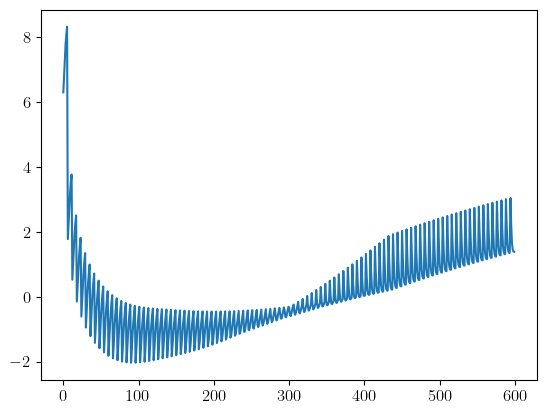

In [263]:
plt.plot(y_pred)

In [464]:
import pickle
with open('data/mcmc_results2/mcmc_results0.pkl', 'rb') as f:
    p0_mcmc, mcmc_sampler = pickle.load(f)

In [465]:
# Import the LCs
lcs = np.load('data/full_lcs_interped.npz', allow_pickle=True)['lcs']
lcs = np.array([lc for lc in lcs if np.mean(lc.snrs) > 3])
for lc in lcs:  # adjust the t explosion
    lc.theta[-1] -= min(lc.times)
    lc.theta[-1] *= -1
lcs.shape

(12525,)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_9939/460273133.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)


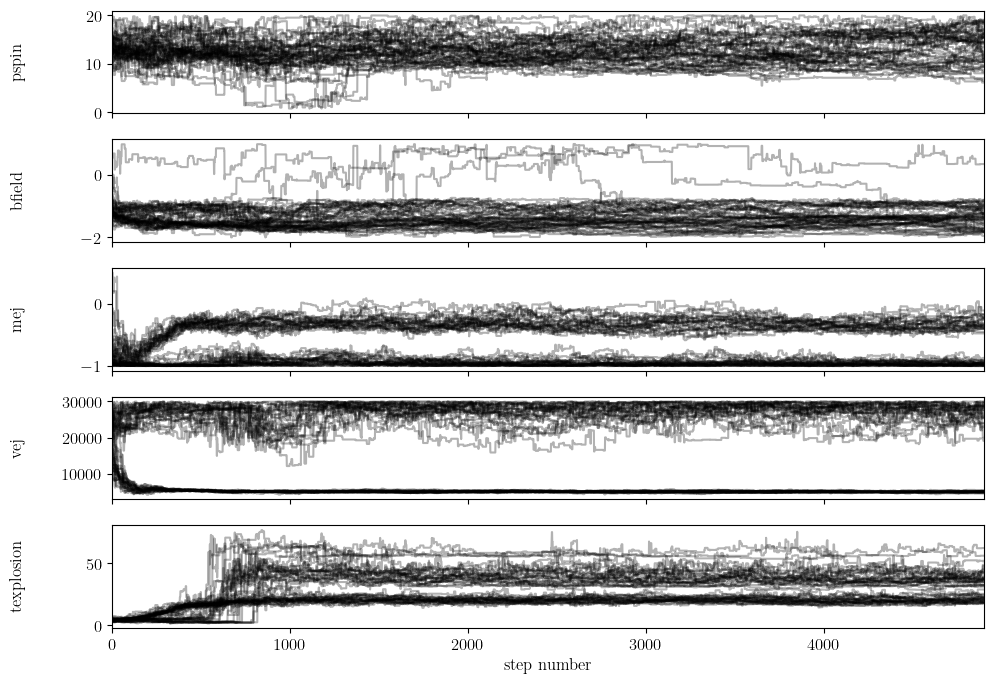

In [383]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = mcmc_sampler.get_chain()
for i in range(5):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(predictor_labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.tight_layout()
plt.show()

In [466]:
i=190

flat_samples = mcmc_sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape, np.array(lcs[i].theta)[predictor_mask].shape)
truth = np.concatenate((np.array(lcs[i].theta)[predictor_mask], [0.9]))
truth[1] = np.log10(truth[1])
truth[2] = np.log10(truth[2])
truth[-2] = lcs[i].times[0] - truth[-2]
fig = corner.corner(
    flat_samples, labels=list(predictor_labels) + ['sigma_n'], truths=truth,
)
plt.show()

(16000, 6) (5,)


AttributeError: 'function' object has no attribute 'corner'

In [ ]:
mcmc_median = np.median(flat_samples, axis=0)

zs = torch.tensor([lc.redshift for lc in lcs]).reshape(-1, 1)
lumdists = cosmo.luminosity_distance(zs)
dist_consts = torch.tensor(np.log10(4. * np.pi * (lumdists.cgs.value) ** 2).reshape(-1, 1))
ts = [np.array(lc.times) - np.min(lc.times) for lc in lcs]

test = torch.tensor(gen_magnetar_model(ts[1] + mcmc_median[4],
                            torch.tensor([mcmc_median[0], 10**mcmc_median[1], mns, thetapb, texp, kappa, kappagamma, 10**mcmc_median[2], mcmc_median[3], tfloor]),
                            filt = lcs[1].filters,
                            redshift=lcs[1].redshift,
                            dist_const=dist_consts[1]))
plt.plot(test)

IndexError: arrays used as indices must be of integer (or boolean) type

# Full SBI results

In [473]:
with open('data/sbi_results0.pkl', 'rb') as f:
    hatp_x_y, p_x_y_estimator = pickle.load(f)

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples: 591it [00:00, 1775.13it/s]                         
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_9939/2980992797.py:4: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = plt.subplots(1, 5, figsize=(15, 4))


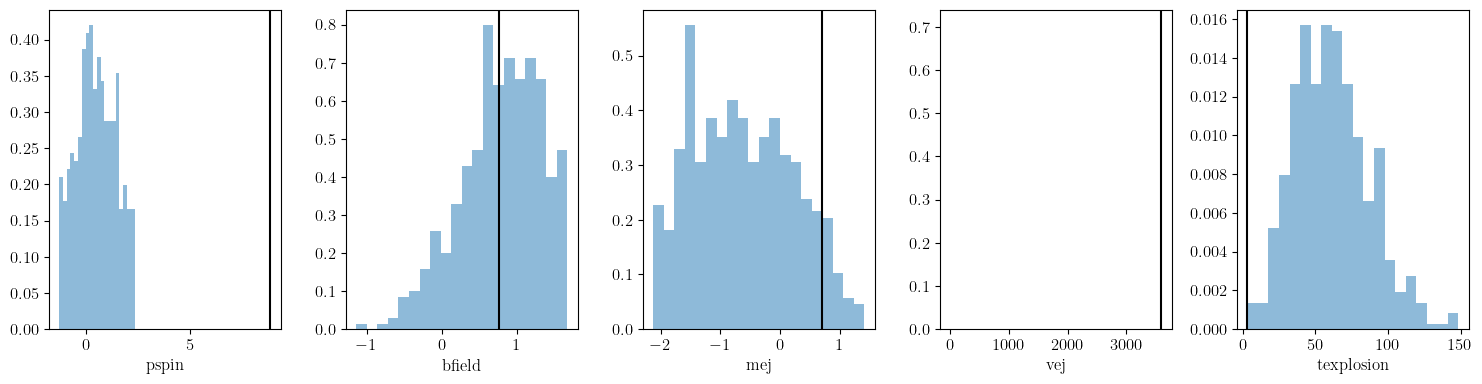

In [474]:
index = 0
samples = hatp_x_y.sample((500,), x=X_test[[index]]).numpy()
thetas = torch.tensor([lc.theta for lc in lcs])[:, predictor_mask]
fig, axes = plt.subplots(1, 5, figsize=(15, 4))
for i in range(5):
    axes[i].hist(samples[:, i], bins=20, alpha=0.5, density=True)
    axes[i].axvline(thetas[index][i], color='k')
    axes[i].set_xlabel(predictor_labels[i])
plt.tight_layout()

/Users/adamboesky/opt/anaconda3/envs/sbi2/lib/python3.12/site-packages/corner/core.py:126: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/adamboesky/opt/anaconda3/envs/sbi2/lib/python3.12/site-packages/corner/core.py:290: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax.set_xscale(axes_scale[i])
/Users/adamboesky/opt/anaconda3/envs/sbi2/lib/python3.12/site-packages/corner/core.py:290: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax.set_xscale(axes_scale[i])
/Users/adamboesky/opt/anaconda3/envs/sbi2/lib/python3.12/site-packages/corner/core.py:799: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax.set_xscale(axes_scale[0])
/Users/adamboesky/opt/anaconda3/envs/sbi2/lib/python3.12/site-packages/corner/core.

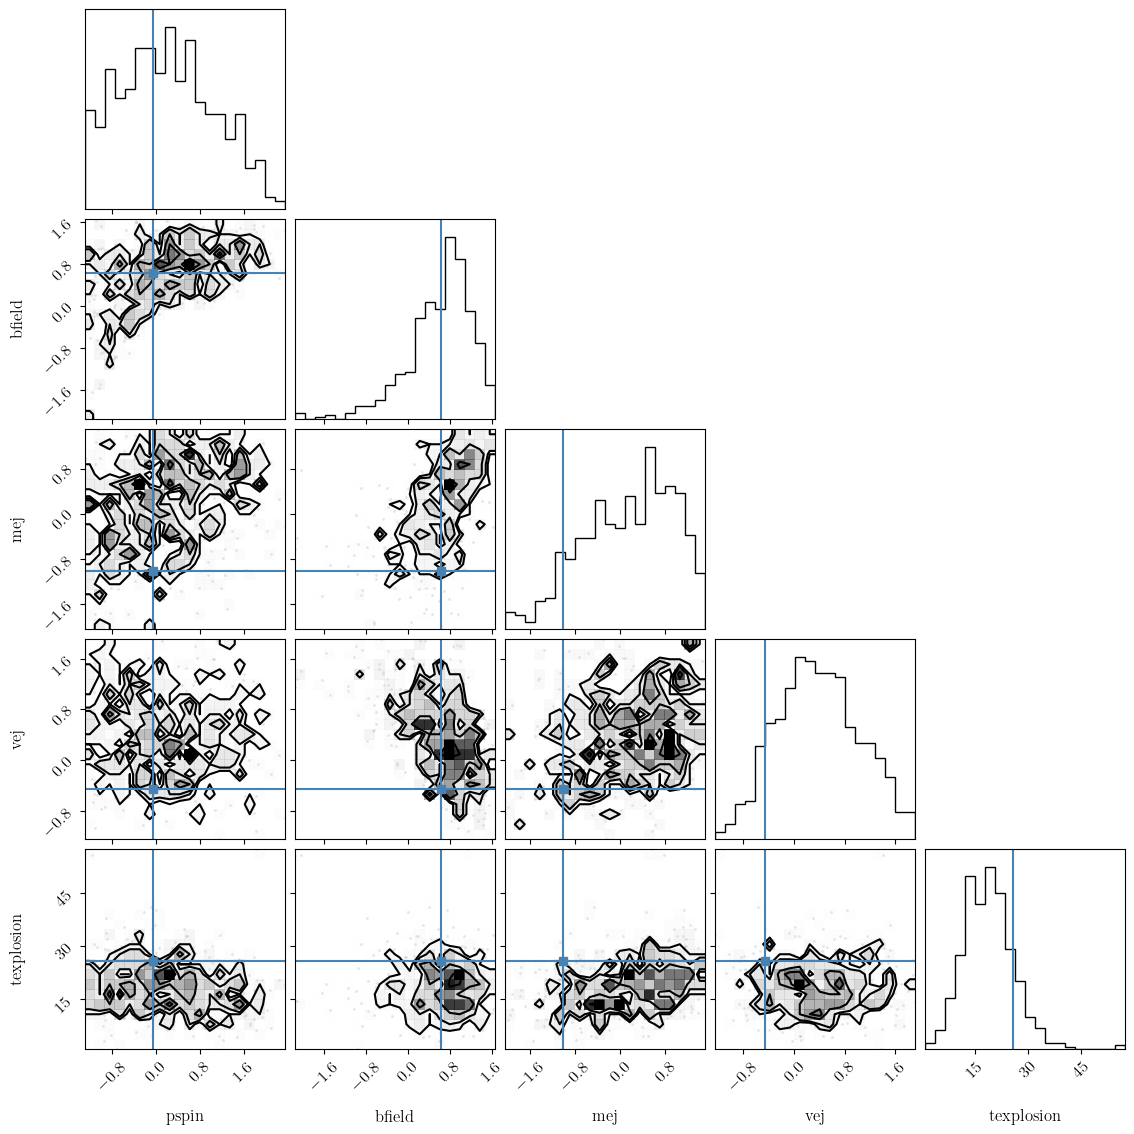

In [285]:
import corner
fig = corner.corner(
    samples, labels=predictor_labels, truths=y_test[index]
)

In [200]:
MCMC_PRIOR, NUM_PARAMS, _ = process_prior([dist.Uniform(low=torch.tensor([0.7]), high=torch.tensor([20.0])),  # pspin
                                           dist.Uniform(low=torch.tensor([-2.0]), high=torch.tensor([1.0])),     #LogUniform(torch.tensor([0.01]), torch.tensor([10])),            # bmag
                                           dist.Uniform(low=torch.tensor([-1.0]), high=torch.tensor([1.3])),      #LogUniform(torch.tensor([0.1]), torch.tensor([10**1.3])),        # mej
                                           TruncatedNormal(torch.tensor([1000]),                            # vej
                                                            torch.tensor([30000]),
                                                            torch.tensor([1.47*1e4]),
                                                            torch.tensor([4.3*1e4])),
                                           dist.Exponential(torch.tensor([0.9])),   # noise
                                           dist.Exponential(torch.tensor([1/27]))   # -1 * texp (mean is 27)
                                        ])

/Users/adamboesky/opt/anaconda3/envs/sbi2/lib/python3.12/site-packages/sbi/utils/user_input_checks.py:76: UserWarning: Prior was provided as a sequence of 6 priors. They will be
            interpreted as independent of each other and matched in order to the
            components of the parameter.
  warnings.warn(
/Users/adamboesky/opt/anaconda3/envs/sbi2/lib/python3.12/site-packages/sbi/utils/user_input_checks.py:209: UserWarning: Casting 1D Uniform prior to BoxUniform to match sbi batch requirements.
  warnings.warn(


In [202]:
### LOAD THE DATA###
print('Importing data!')
# Import the LCs
lcs = np.load('data/full_lcs_interped.npz', allow_pickle=True)['lcs']
lcs = np.array([lc for lc in lcs if np.mean(lc.snrs) > 3])
for lc in lcs:  # adjust the t explosion
    lc.theta[-1] -= min(lc.times)
    lc.theta[-1] *= -1
lcs.shape
lcs = lcs[:1000]

# Split into test and train
predictor_mask = np.array([ True,  True, False, False, False, False, False,  True,  True, False,  True]) # Mask for theta that only gets what we actually care about
all_predictor_labels = np.array(['pspin', 'bfield', 'mns', 'thetapb', 'texp', 'kappa', 'kappagamma', 'mej', 'vej', 'tfloor', 'texplosion'])
predictor_labels = all_predictor_labels[predictor_mask]
print(f'theta = {predictor_labels}')

# Tensorize the data
ts = torch.tensor([lc.times_interped for lc in lcs])
thetas = torch.tensor([lc.theta for lc in lcs])[:, predictor_mask]
filters = torch.tensor([ugrizy_to_numbers(lcs[0].filters).astype(int)])
zs = torch.tensor([lc.redshift for lc in lcs]).reshape(-1, 1)
# lumdists = cosmo.luminosity_distance(zs)
# dist_consts = torch.tensor(np.log10(4. * np.pi * (lumdists.cgs.value) ** 2).reshape(-1, 1))
# ys = torch.tensor([lc.mags_interped for lc in lcs])
# yerrs = torch.tensor([lc.magerrs_interped for lc in lcs])


nwalkers = 50
p0 = MCMC_PRIOR.sample(sample_shape=torch.Size([50,]))
dtype = [("log_prior", float), ("mean", float)]

Importing data!
theta = ['pspin' 'bfield' 'mej' 'vej' 'texplosion']


In [239]:
### LOAD THE DATA###
print('Importing data!')

# Import the LCs
lcs = np.load('data/full_lcs_interped.npz', allow_pickle=True)['lcs']
lcs = np.array([lc for lc in lcs if np.mean(lc.snrs) > 3])
for lc in lcs:  # adjust the t explosion
    lc.theta[-1] -= min(lc.times)
    lc.theta[-1] *= -1
lcs.shape
lcs = lcs[:1000]

# Split into test and train
predictor_mask = np.array([ True,  True, False, False, False, False, False,  True,  True, False,  True]) # Mask for theta that only gets what we actually care about
all_predictor_labels = np.array(['pspin', 'bfield', 'mns', 'thetapb', 'texp', 'kappa', 'kappagamma', 'mej', 'vej', 'tfloor', 'texplosion'])
predictor_labels = all_predictor_labels[predictor_mask]
print(f'theta = {predictor_labels}')

# Tensorize the data
ts = torch.tensor([lc.times - np.min(lc.times) for lc in lcs])
thetas = torch.tensor([lc.theta for lc in lcs])[:, predictor_mask]
filters = torch.tensor([ugrizy_to_numbers(lcs[0].filters).astype(int)])
zs = torch.tensor([lc.redshift for lc in lcs]).reshape(-1, 1)
lumdists = cosmo.luminosity_distance(zs)
dist_consts = torch.tensor(np.log10(4. * np.pi * (lumdists.cgs.value) ** 2).reshape(-1, 1))
ys = torch.tensor([lc.mags for lc in lcs])
yerrs = torch.tensor([(1/lc.snr) * lc.mags for lc in lcs])

nwalkers = 50
p0 = MCMC_PRIOR.sample(sample_shape=torch.Size([50,]))
dtype = [("log_prior", float), ("mean", float)]

Importing data!
theta = ['pspin' 'bfield' 'mej' 'vej' 'texplosion']


ValueError: expected sequence of length 163 at dim 1 (got 98)

In [242]:
lcs[0].times

array([63150.20357669, 63150.20440196, 63150.2272496 , 63150.22814746,
       63150.36921781, 63150.36966544, 63150.37875068, 63150.37919827,
       63151.22734215, 63151.25125717, 63154.1886487 , 63154.21076214,
       63154.21254455, 63155.36157156, 63155.37436837, 63156.3377178 ,
       63156.36330404, 63158.35243298, 63158.36392724, 63159.35649555,
       63159.36838158, 63159.3701992 , 63162.35317643, 63162.36268276,
       63164.19245847, 63164.19291028, 63166.21521065, 63168.33247382,
       63171.34312301, 63171.35447179, 63172.31597263, 63173.33232361,
       63173.34364665, 63175.13135348, 63175.15545934, 63177.13728563,
       63177.16108135, 63180.04867778, 63180.07235451, 63180.08293903,
       63181.31889581, 63181.33520354, 63182.30697391, 63187.268656  ,
       63187.29115052, 63187.31782456, 63187.32908475, 63188.29808412,
       63191.27673135, 63191.29699611, 63193.27165191, 63193.29756513,
       63194.24217609, 63194.26484278, 63195.29017832, 63195.29062717,
      

In [246]:
ts = [lc.times - np.min(lc.times) for lc in lcs]
ts = torch.tensor(ts)

ValueError: expected sequence of length 163 at dim 1 (got 98)

/Users/adamboesky/Research/SBI_205/models/magnetar_model.py:62: RuntimeWarning: divide by zero encountered in power
  multiplier =  (1.0 - np.exp(-A*test_t**-2)) * np.exp(-(test_t/tau_diff)**2)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_9939/780398207.py:10: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(test_lc)


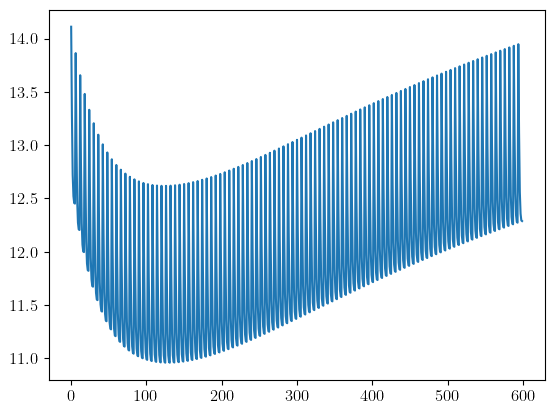

In [216]:
ind = 3
theta_t = p0[ind].detach().numpy()
dist_const = dist_consts[ind]
test_lc = gen_magnetar_model(time_grid + theta_t[-1],
                                torch.tensor([theta_t[0], 10**theta_t[1], mns, thetapb, texp, kappa, kappagamma, 10**theta_t[2], theta_t[3], tfloor]),
                                filt=filt_grid,
                                redshift=0.1,
                                dist_const=dist_const)

plt.plot(test_lc)

In [207]:
# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, NUM_PARAMS, log_probability, args=(ys, yerrs, zs, dist_consts), blobs_dtype=dtype)

# Run 100 burn in steps :)
print('Started burn')
burn_results = sampler.run_mcmc(p0, 100, progress=True)
print('Finished burn')
sampler.reset()

# Do the final sampling
print('Started final sampling')
final_results = sampler.run_mcmc(burn_results, 1000, progress=True)
print('Finished final sampling')

Started burn


/Users/adamboesky/Research/SBI_205/models/magnetar_model.py:62: RuntimeWarning: divide by zero encountered in power
  multiplier =  (1.0 - np.exp(-A*test_t**-2)) * np.exp(-(test_t/tau_diff)**2)
/Users/adamboesky/Research/SBI_205/models/magnetar_model.py:60: RuntimeWarning: overflow encountered in exp
  integrand = 2* lum_inp * test_t/tau_diff * np.exp((test_t/tau_diff)**2)  * 1e52
/Users/adamboesky/Research/SBI_205/models/magnetar_model.py:60: RuntimeWarning: overflow encountered in multiply
  integrand = 2* lum_inp * test_t/tau_diff * np.exp((test_t/tau_diff)**2)  * 1e52
/Users/adamboesky/Research/SBI_205/models/magnetar_model.py:63: RuntimeWarning: invalid value encountered in multiply
  l_out = multiplier * cumtrapz(integrand, test_t, initial = 0)
/Users/adamboesky/Research/SBI_205/models/magnetar_model.py:75: RuntimeWarning: overflow encountered in power
  radius = np.sqrt(luminosities / (STEF_CONST * temperature**4))
/Users/adamboesky/Research/SBI_205/models/magnetar_model.py:75: 

emcee: Exception while calling your likelihood function:
  params: [ 1.81614380e+01 -1.74189538e+00  9.59230179e-01  1.84672706e+04
 -3.13098106e-01 -2.04873155e+01]
  args: (tensor([[ 6.1694,  6.6309,  7.0861,  ...,  2.0006,  2.2281,  2.5361],
        [13.6478, 13.1574, 12.8581,  ...,  5.6136,  5.6587,  5.8247],
        [16.0029, 15.1677, 14.7969,  ..., 12.8451, 12.8614, 13.1277],
        ...,
        [21.0716, 20.8551, 20.7238,  ..., 20.1594, 20.0561, 20.0334],
        [17.3030, 16.5723, 16.1993,  ..., 17.1597, 17.1569, 17.1859],
        [16.5487, 17.0339, 17.5780,  ..., 21.3465, 21.2198, 21.1208]],
       dtype=torch.float64), tensor([[1.4310e-06, 1.0093e-03, 8.0171e-07,  ..., 4.7140e-03, 3.3163e-03,
         2.1201e-06],
        [5.5783e-05, 3.0541e-03, 2.3316e-06,  ..., 1.0693e-02, 8.3040e-03,
         1.6587e-03],
        [2.7486e-01, 3.2174e-05, 1.5704e-05,  ..., 6.9488e-03, 1.5877e-04,
         2.8114e-05],
        ...,
        [7.4111e-02, 3.3251e-02, 2.3172e-02,  ..., 8.7251e

ValueError: A value (-20.38731547989486) in x_new is below the interpolation range's minimum value (0.0).